<a href="https://colab.research.google.com/github/risker93/Hello_World/blob/main/daily/2021_07_16_%E1%84%8C%E1%85%A1%E1%84%8B%E1%85%A7%E1%86%AB%E1%84%8B%E1%85%A5%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 한국어데이터로 QA(Question Answering)하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install customized_konlpy

     |████████████████████████████████| 890kB 5.0MB/s 
     |████████████████████████████████| 450kB 32.1MB/s 
     |████████████████████████████████| 19.4MB 8.8MB/s 
     |████████████████████████████████| 92kB 8.8MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
from ckonlpy.tag import Twitter
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [ ]:
train_file = os.path.join('/content/drive/MyDrive/qa1_single-supporting-fact_train_kor.txt')
test_file = os.path.join('/content/drive/MyDrive/qa1_single-supporting-fact_test_kor.txt')

In [ ]:
i = 0
lines = open(train_file, "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i+1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [ ]:
def read_data(dir):
    stories, questions, answers = [], [], []
    story_temp = []
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 분리
        line = line.strip() # \n 제거 
        idx, text = line.split(" ", 1) # 맨앞에 있는 id number 분리

        if int(idx) == 1:
            story_temp = []

        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인경우
            question, answer, _ = text.split("\t")
            stories.append([x for x in story_temp if x])
            questions.append(question)
            answers.append(answer)
        else: 
            story_temp.append(text)
    lines.close()
    return stories, questions, answers

In [ ]:
train_data = read_data(train_file)
test_data = read_data(test_file)

In [ ]:
train_stories, train_questons, train_answers = read_data(train_file)
test_stories, test_questions, test_answers = read_data(test_file)

In [ ]:
print('훈련용 스토리의 갯수 : ', len(train_stories))
print('훈련용 질문의 갯수 :', len(train_questons))
print('훈련용 답변의 갯수 :', len(train_answers))
print('테스트용 스토리의 갯수 :', len(test_stories))
print('테스트용 질문의 갯수 :', len(test_questions))
print('테스트용 답변의 갯수 :', len(test_answers))

훈련용 스토리의 갯수 :  10000
훈련용 질문의 갯수 : 10000
훈련용 답변의 갯수 : 10000
테스트용 스토리의 갯수 : 1000
테스트용 질문의 갯수 : 1000
테스트용 답변의 갯수 : 1000


In [ ]:
train_stories[3678]

['필웅이는 사무실로 복귀했습니다.',
 '은경이는 화장실로 가버렸습니다.',
 '수종이는 사무실로 갔습니다.',
 '수종이는 복도로 가버렸습니다.',
 '수종이는 사무실로 이동했습니다.',
 '수종이는 정원으로 뛰어갔습니다.',
 '은경이는 침실로 복귀했습니다.',
 '수종이는 화장실로 복귀했습니다.']

In [ ]:
train_questons[3678]

'은경이는 어디야? '

In [ ]:
train_answers[3678]

'침실'

### 토큰화

In [ ]:
twitter = Twitter()

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
twitter.add_dictionary('은경이','Noun')
twitter.add_dictionary('경임이','Noun')
twitter.add_dictionary('수종이','Noun')

In [ ]:
def tokenize(sent):
    #return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()]
    return twitter.morphs(sent)

In [ ]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()

    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []

    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [ ]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [ ]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [ ]:
vocab_size = len(word2idx)+1
print(vocab_size)

24


In [ ]:
print('스토리의 최대 길이 :', story_max_len)
print('질문의 최대 길이 :', question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


In [ ]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x+ y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        y.append(word2idx[answer])

    return pad_sequences(Xs, maxlen=story_maxlen),\
    pad_sequences(Xq, maxlen=question_maxlen),\
    to_categorical(y, num_classes=len(word2idx) + 1)

In [ ]:
xstrain, xqtrain, ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
xstest, xqtest, ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [ ]:
print(xstrain.shape, xqtrain.shape, ytrain.shape, xstest.shape, xqtest.shape, ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


## 메모리 네트워크만들기

![](https://wikidocs.net/images/page/82475/memn.PNG)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation

In [ ]:
train_epochs = 120
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.3

In [ ]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 70), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 5), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
# Embeddig A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim= embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# (샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원)

# Embedding C
# 임베딩 벡터의 차원을 질문의 최대 길이로!
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim = question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# (샘플의 수, 문장의 최대길이, 질문의최대길이(임베딩벡터의차원))

In [ ]:
# 질문을 위한 임베딩 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# (샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원)

In [ ]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 70, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 5, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [ ]:
match = dot([input_encoded_m, question_encoded], axes= -1, normalize=False) ##
match = Activation('softmax')(match)
print('Match shape', match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)
print('Response shape', response)

answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 70, 5), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")
Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 70), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 5, 120), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 50)     1200        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5, 50)        1200        input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
history = model.fit([xstrain, xqtrain],
                    ytrain, batch_size, train_epochs,
                    validation_data = ([xstest, xqtest], ytest))

model.save('model.h5')

Epoch 1/120
313/313 [==============================] - 7s 14ms/step - loss: 1.9257 - acc: 0.1694 - val_loss: 1.7976 - val_acc: 0.1870
Epoch 2/120
313/313 [==============================] - 3s 11ms/step - loss: 1.7645 - acc: 0.2230 - val_loss: 1.6271 - val_acc: 0.3420
Epoch 3/120
313/313 [==============================] - 3s 11ms/step - loss: 1.5705 - acc: 0.3766 - val_loss: 1.4682 - val_acc: 0.4540
Epoch 4/120
313/313 [==============================] - 3s 10ms/step - loss: 1.4663 - acc: 0.4429 - val_loss: 1.3964 - val_acc: 0.4750
Epoch 5/120
313/313 [==============================] - 3s 10ms/step - loss: 1.3990 - acc: 0.4769 - val_loss: 1.3419 - val_acc: 0.4940
Epoch 6/120
313/313 [==============================] - 3s 10ms/step - loss: 1.3454 - acc: 0.4887 - val_loss: 1.3284 - val_acc: 0.4850
Epoch 7/120
313/313 [==============================] - 3s 10ms/step - loss: 1.3105 - acc: 0.4944 - val_loss: 1.2505 - val_acc: 0.5230
Epoch 8/120
313/313 [==============================] - 3s 10ms

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


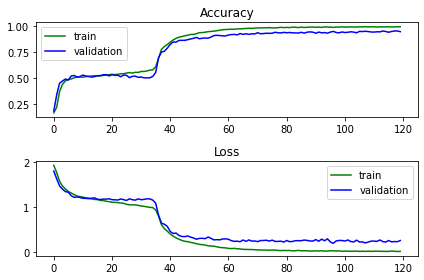

In [ ]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color='g', label="train")
plt.plot(history.history["val_acc"], color='b', label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label='train')
plt.plot(history.history["val_loss"], color='b', label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(ytest, axis=1)

# get predictions
ytest_ = model.predict([xstest, xqtest])
ytest_ = np.argmax(ytest_, axis=1)

In [ ]:
num_display = 30

print("{:18}|{:5}|{}".format("질문","실제값","예측값"))
print(39 * "_")

for i in range(num_display):
    question = " ".join([idx2word[x] for x in xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}|{:7}|{}".format(question, label, prediction))

질문                |실제값  |예측값
_______________________________________
은경이 는 어디 야 ?        |복도     |복도
필웅이 는 어디 야 ?        |화장실    |화장실
경임이 는 어디 야 ?        |부엌     |부엌
경임이 는 어디 야 ?        |복도     |복도
경임이 는 어디 야 ?        |부엌     |부엌
경임이 는 어디 야 ?        |복도     |복도
경임이 는 어디 야 ?        |정원     |정원
수종이 는 어디 야 ?        |복도     |복도
경임이 는 어디 야 ?        |사무실    |사무실
수종이 는 어디 야 ?        |사무실    |사무실
필웅이 는 어디 야 ?        |부엌     |부엌
필웅이 는 어디 야 ?        |정원     |정원
수종이 는 어디 야 ?        |사무실    |사무실
필웅이 는 어디 야 ?        |침실     |침실
필웅이 는 어디 야 ?        |침실     |침실
은경이 는 어디 야 ?        |부엌     |부엌
은경이 는 어디 야 ?        |정원     |정원
은경이 는 어디 야 ?        |부엌     |부엌
수종이 는 어디 야 ?        |사무실    |사무실
은경이 는 어디 야 ?        |부엌     |복도
필웅이 는 어디 야 ?        |복도     |복도
은경이 는 어디 야 ?        |사무실    |사무실
은경이 는 어디 야 ?        |사무실    |사무실
경임이 는 어디 야 ?        |복도     |복도
수종이 는 어디 야 ?        |침실     |침실
경임이 는 어디 야 ?        |침실     |침실
필웅이 는 어디 야 ?        |침실     |침실
수종이 는 어디 야 ?        |부엌     |부엌
수종이 는 어디 야 ?        |부엌     

## Transformer(트랜스포머)

seq2seq모델 encoder-decoder구조 
기존 seq2seq모델의 한계
- 입력시퀀스를 하나의 벡터표현으로 압축(context vector)디코더는 이를 통해 출력 시퀀스 만들어냈는데, 정보가 일부 손실된다는 단점 존재. 


- d_model = 512
- num_layers = 6
- num_heads = 8
- d_ff = 2048

![](https://wikidocs.net/images/page/31379/transformer1.PNG)

![](https://wikidocs.net/images/page/31379/transformer2.PNG)

![](https://wikidocs.net/images/page/31379/transformer4_final_final_final.PNG)

### 포지셔널 인코딩
![](https://wikidocs.net/images/page/31379/transformer5_final_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer6_final.PNG)

![](https://wikidocs.net/images/page/31379/transformer7.PNG)

In [ ]:
import tensorflow as tf

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    def get_angles(self, position, i, d_model):
        angles = 1/tf.pow(10000, (2*(i//2))/tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position= tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model = d_model
        )

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        angle_rads = np.zeros(angle_rads.shape)
        angle_rads[:, 0::2] = sines
        angle_rads[:, 1::2] = cosines
        pos_encoding = tf.constant(angle_rads)
        pos_encoding = pos_encoding[tf.newaxis, ...]   ### [1, 1, 1, :, :, :]

        print(pos_encoding.shape)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

(1, 50, 128)


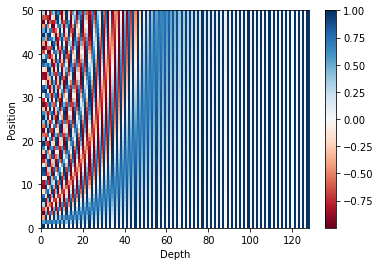

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()


### 어텐션 (Attention)

![](https://wikidocs.net/images/page/31379/attention.PNG)

```
인코더의 셀프 어텐션 : Query = Key = Value  
디코더의 마스크드 셀프 어텐션 : Query = Key = Value  
디코더의 인코더-디코더 어텐션 : Query :디코더 벡터 // Key=Value : 인코더 벡터  
```

### 인코더

```
seq2seq 어텐션의 이점  
- query와 key의 유사도를 구함
Query : 모든 시점의 디코더 셀에서의 은닉 상태
keys : 모든 시점의 인코더 셀의 은닉 상태
value : 모든 시점의 인코더 셀의 은닉 상태
```

```
트랜스포머의 어텐션
Q : 입력 문장의 모든 단어 벡터
K : 입력 문장의 모든 단어 벡터
V : 입력 문장의 모든 단어 벡터
```

![](https://wikidocs.net/images/page/31379/transformer10.png)

### Q, K, V벡터 얻기

![](https://wikidocs.net/images/page/31379/transformer11.PNG)

- d_model = 512
- num_heads = 8
- q,k,v vector = 64

### 스케일드 닷- 프로덕트 어텐션 구현하기

![](https://wikidocs.net/images/page/31379/transformer13.PNG)

![](https://wikidocs.net/images/page/31379/transformer14_final.PNG)

$d_k = d_{modle}$/num_heads --> 64값

In [51]:
def scaled_dot_product_attention(query, key, value, mask):
    # query크기 : (batch_size, num_heads, query의 문장길이, d_model/hum_heads)
    # key크기 : (batch_size, num_heads, key의 문장길이, d_model/hum_heads)
    # value크기 : (batch_size, num_heads, value의 문장길이, d_model/hum_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장길이)

    matmul_qk = tf.matmul(query, key, transpose_b = True) 

    # 스케일링
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 마스킹
    if mask is not None:
        logits += (mask * -1e9)
    
    # attention_weights (batch_size, num_heads, query문장길이, key의 문장길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output, attention_weights

In [52]:
import numpy as np
import tensorflow as tf

In [53]:
np.set_printoptions(suppress=True)
temp_k = tf.constant([[10,0,0],
                     [0,10,0],
                     [0,0,10],
                     [0,0,10]], dtype = tf.float32)
temp_v = tf.constant([[1,0],
                     [10,0],
                     [100,5],
                     [1000,6]], dtype = tf.float32)
temp_q = tf.constant([[0,10,0]], dtype = tf.float32)

In [54]:
temp_out, temp_attn= scaled_dot_product_attention(temp_q, temp_k, temp_v, None)

In [ ]:
print(temp_attn) # 어텐션 분포
print(tmep_out) # 어텐션 값

In [ ]:
#temp_k = tf.constant([[10,0,0],
#                     [0,10,0],
#                     [0,0,10],
#                     [0,0,10]], dtype = tf.float32)
#temp_v = tf.constant([[1,0],
#                     [10,0],
#                     [100,5],
#                     [1000,6]], dtype = tf.float32)
#temp_q = tf.constant([[0,10,0]], dtype = tf.float32)


temp_q = tf.constant([[0,0,10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

In [ ]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0],[10, 10, 0]],dtype=tf.float32) # (3, 3)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

### 멀티 헤드 어텐션

![](https://wikidocs.net/images/page/31379/transformer17.PNG)


    1. WQ, Wk, Wv에 해당하는 d_model 크기의 Dense_layer 을 지나게 한다
    2. 지정된 헤드 수 (num_heads)만큼 나눈다.
    3. 스케일드 닷 프로덕트 어텐션,
    4. 나눠졌던 헤드들을 연결
    5. Wo에 해당하는 Dense layer을 지난다.


In [46]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_head로 나눈값 --> 64
    self. depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # w0 dense layer
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 갯수만큼 q, k, v split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)
    )
    return tf.transpose(inputs, perm=[0,2,1,3])

  def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, Wk, Wv에 해당하는 d_model크기의 Dense layer을 지나게 한다.
        # q: (batch_size, query의 문장길이 , d_model)
        # k: (batch_size, key의 문장길이 , d_model)
        # v: (batch_size, value의 문장길이 , d_model)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드나누기
        # q : (batch_size, query의 문장길이, d_model/num_heads)
        # k : (batch_size, key의 문장길이, d_model/num_heads)
        # v : (batch_size, value의 문장길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

         # 3. 스케일드 닷 프로덕트 어텐션
        #(batch_size, num_heads , query의 문장길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        #(batch_size, query의 문장길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        # 5. wo에 해당하는 dense layers 지나기
        outputs = self.dense(concat_attention)

        return outputs

## 패딩마스크

![](https://wikidocs.net/images/page/31379/pad_masking11.PNG)

![](https://wikidocs.net/images/page/31379/pad_masking2.PNG)

![](https://wikidocs.net/images/page/31379/softmax.PNG)

## 포지션-와이즈 피드 포워드 신경망

![](https://wikidocs.net/images/page/31379/positionwiseffnn.PNG)

## 잔차 연결(residual connection)

![](https://wikidocs.net/images/page/31379/transformer22.PNG)

## 인코더 구현하기